# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

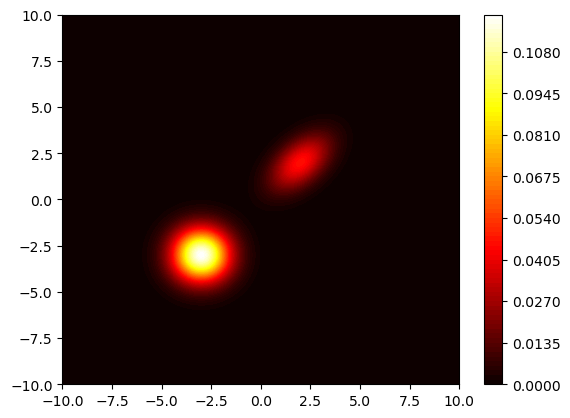

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
We have two modes, (-2.5, -2.5) and (2.5, 2.5). The most probable point is (-2.5, -2.5)

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
In this case it is Gaussian distribution

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
Yes, my proposal is a proper proposal distribution. The proposal is irreducible as for every xnew and xold, q(xnew|xold) >0. The proposal is aperiodic as there are no cycles.

In [15]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.


class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        # PLEASE FILL IN
        # normal distribution centered at x with standard deviation self.std
        x_new = np.random.normal(x, self.std, size=x.shape)
        return x_new

    def evaluate(self, x_new, x_old):
        # Acceptence ratio is calcualted by dividing probability of state x_new to probability of state x_old
        A = self.prob(x_new)/ self.prob(x_old)
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # PLEASE FILL IN
        # generate a random number between 0 and 1 and compare it with acceptance probability A
        u = np.random.uniform(0,1,1)
        if A> u:
            return x_new
        else:
            return self.x_old
        # NOTE: If a new candidate is not selected, we must return self.x_old

    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [16]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

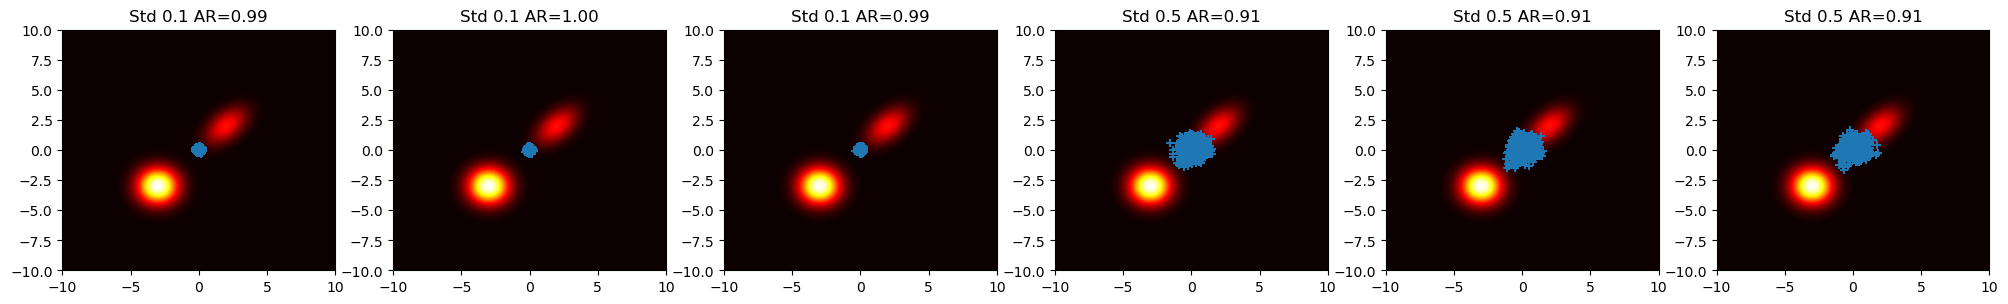

In [17]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**: If the standard deviation is too low, Metropolis-Hastings algorithm doesn't sample from other modes.It only explores one mode. However, if the standard deviation is too high, the algorithm does not effectively explore the distribution, it samples from more nodes. It is not always possible to sample from both nodes in theory. From plots, I observed that wehen the std is 0.1, samples are closer to one mode, they only explore one mode. However, when the std is 0.5, there are jumps and more sampling from the nodes, the algorithm samples from both of the modes.

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: When std is 0.1, when std is lower, acceptance ratio is high. And the algorithm does not choose points far from the old point. Thus, When std is lower, more sample points are accepted. When std is 0.5 and higher, we can observe that acceptance ratio is lower, as far points from the old point get accepted. The acceptance score and ratio is lower. The difference is because of that when std is 0.5, the proposed distribution is far from the old state and hence acceptence ratio is lower, when std is 0.1, proposed points are closer and similar to old state, thus higher acceptance ratio.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: In MH, there is random sampling however in SA, there is a sampling according to a temperature value which shows the density. In MH, the acceptance of a proposed state is determined by the acceptance probability. In SA, it is determined by the difference between the objectvie functions on proposed and current states.

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: SA generally has a better performance than MH. It is beacuse that SA can arrange the temperature to exploit more the objective function. MH explores the target distribution. SA can converge to global minimum of the objective funciton compared to MH, thus more efficient for optimization. I would use SA for optimization.

In [26]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        # PLEASE FILL IN
        # normal distribution centered at x with standard deviation self.std
        # added gaussian noise to the point
        x_new = np.random.normal(x, self.std, size=x.shape) + x
        return x_new

    def evaluate(self, x_new, x_old, T):
        # PLEASE FILL IN
        # the difference between objective functions for different states is calculated, then A is calculated using temperature T
        diff = self.prob(x_new)- self.prob(x_old)
        A = np.exp(diff / T)
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # PLEASE FILL IN
        # generate a random number between 0 and 1 and compare it with acceptance probability A
        u = np.random.uniform(0,1,1)
        if A> u:
            return x_new
        else:
            return self.x_old

    def step(self):
        # The temperature scheme (the cooling scheme)
        # PLEASE FILL IN
        T = pow(self.C * np.log(self.t + self.T0), -1)
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

/var/folders/0m/4f8p309n38dgcm6s7hjkbtx00000gn/T/ipykernel_28790/222424851.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  T = pow(self.C * np.log(self.t + self.T0), -1)


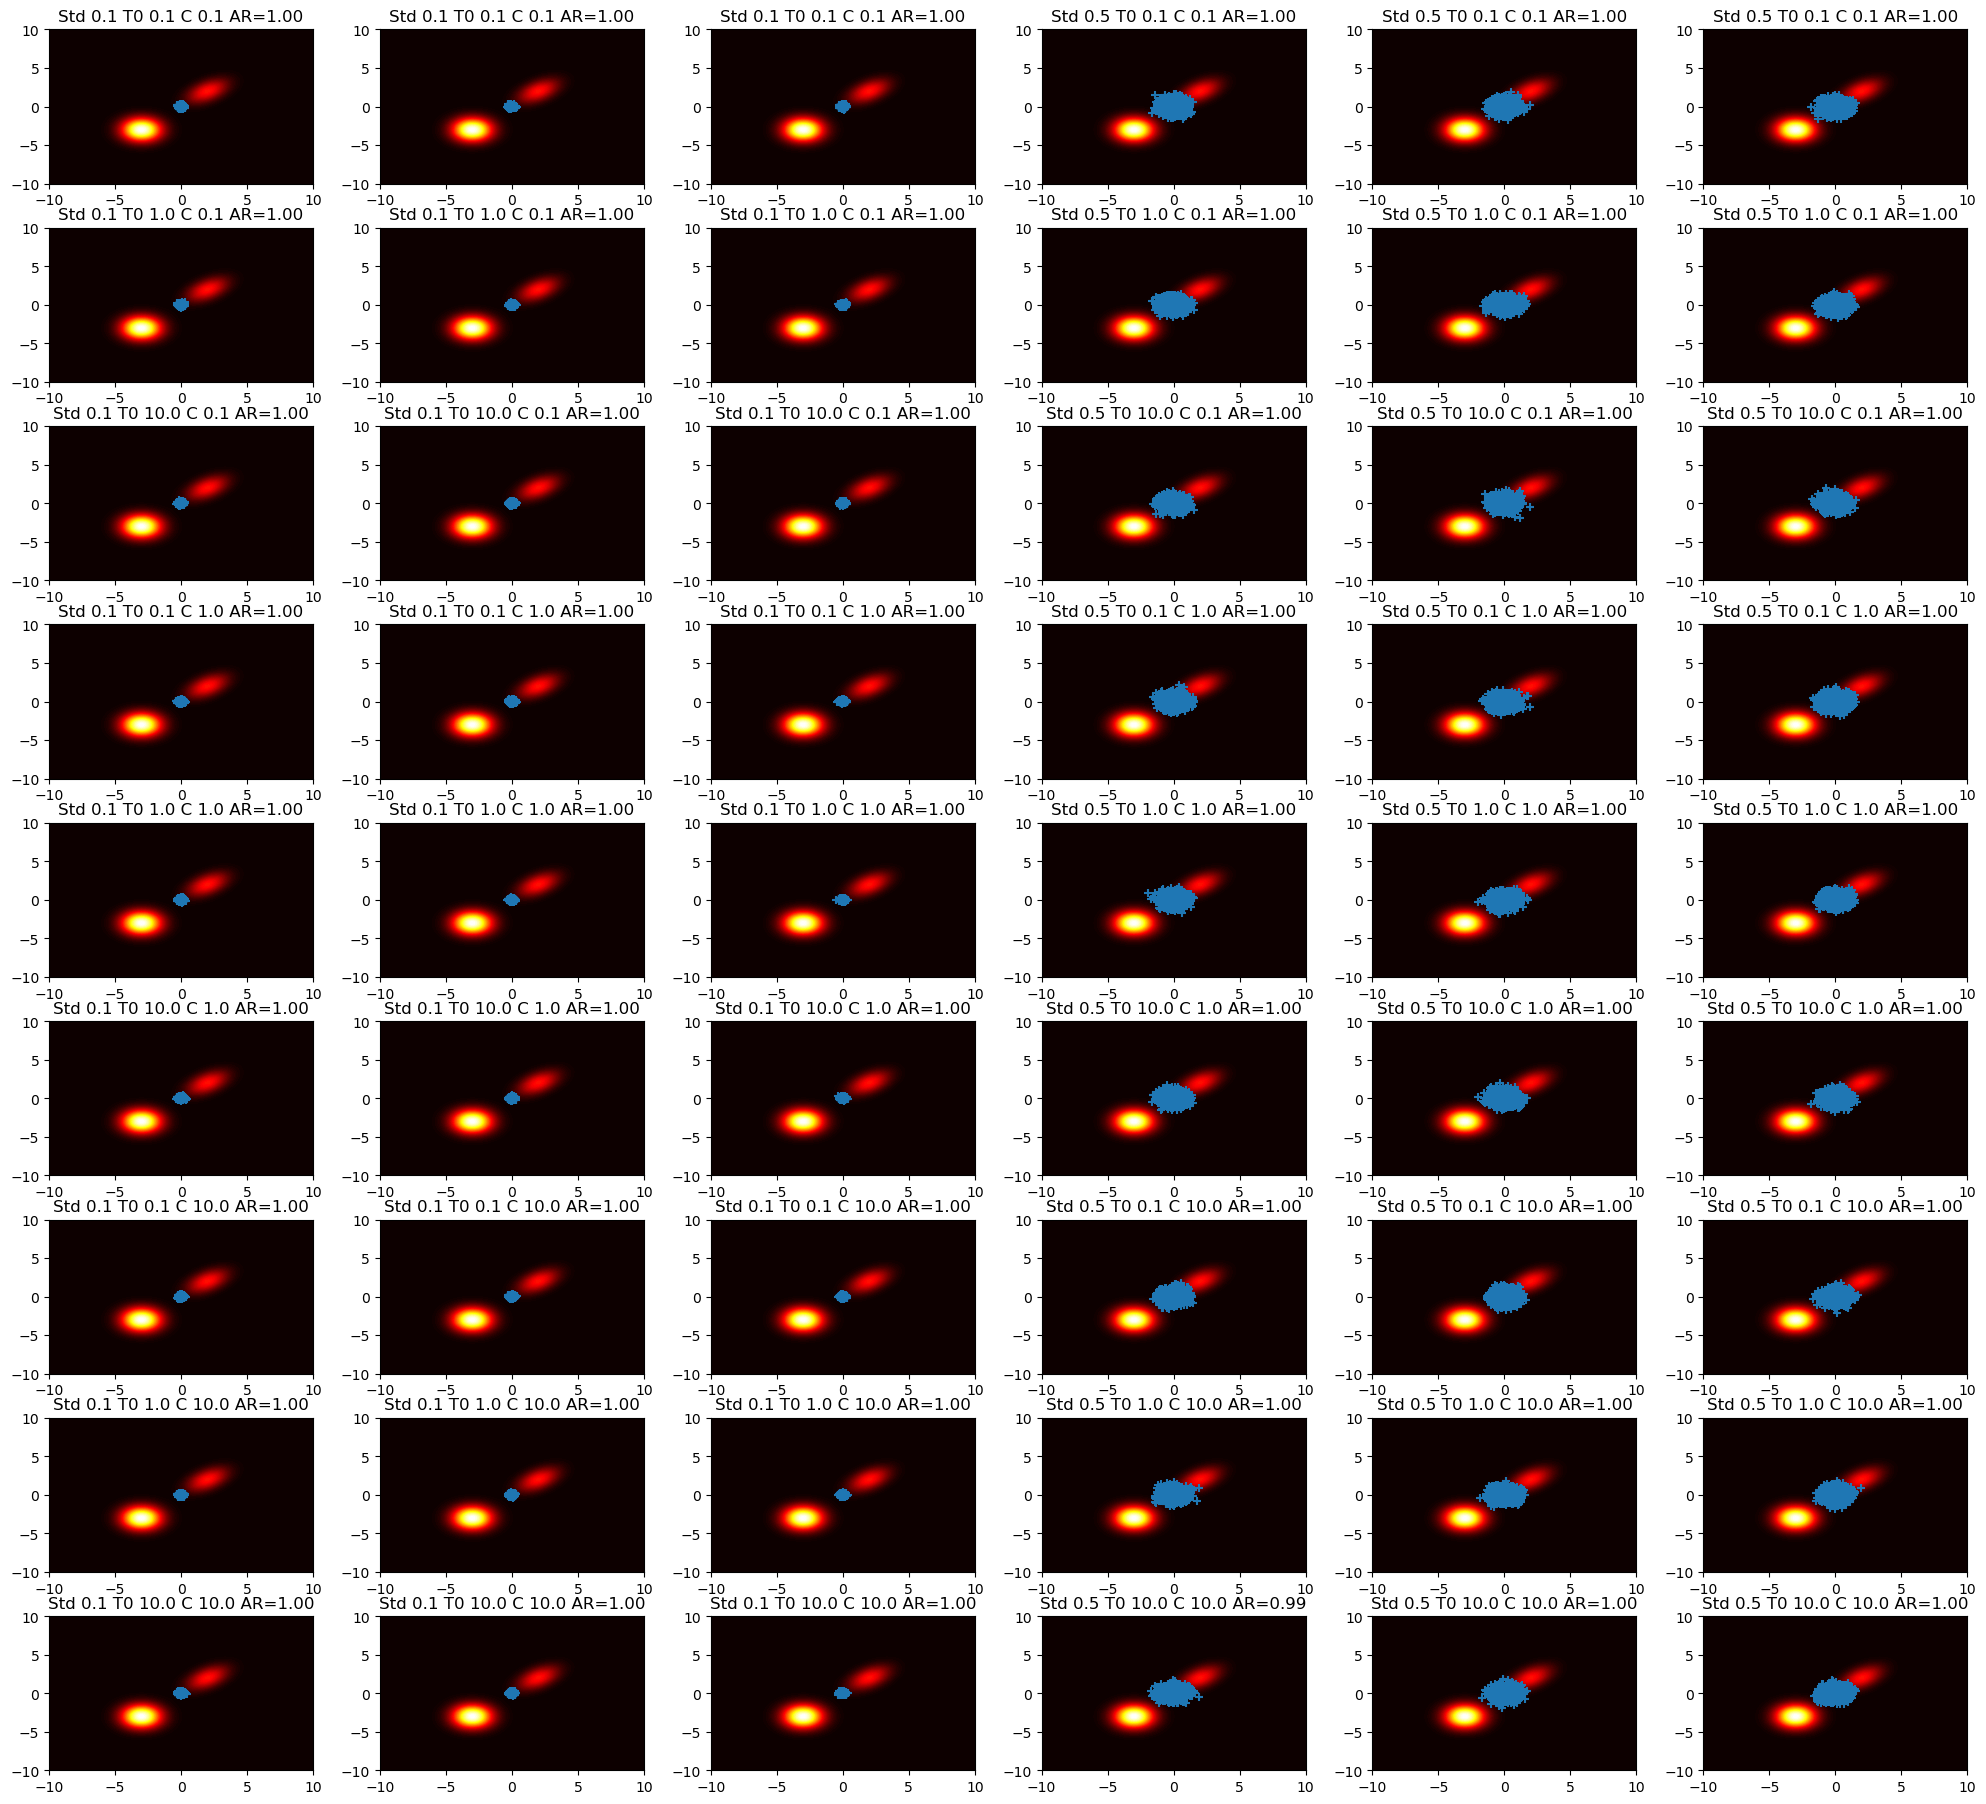

In [27]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** When the standard deviation is low, the simulated annealing algorithm explores near points of the current state.Thus, the algorithm cannot effectively find the optimal solution. When the standard deviation is high, distant solutions from the current state are accepted more compared to the case of low standard deviation. 

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** When the initial temperature is high, the simulated annealing algorithm samples from different directions. Algorithm accepts points in that case. Thus, the acceptence ratio is higher. When the initial temperature is low, the algorithm accepts closer solutions and the algorithm is more selective hence the acceptence ratio is lower in this case.


**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** When the constant C is high, the temperature T decreases faster. When the constant C is low, the temperature T decreases slower. It explores more in that case and the acceptence ratio is higher.

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** The goal is to find the optimal solution quickly and with high probability. So, I guess that the setting std=0.5 T0=0.1 C=0.1 performed the best in terms of sampling.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** From the results above, we can see that when the std is high, AR is low. When std is low, the AR is high. It is beacuse of thath when the standard deviation is high, distant solutions from the current state are accepted more. When the initial temperature T0 is high, AR is high as the simulated annealing algorithm samples from different directions. When the initial temperature T0 is low, AR is low. When the constant C is low, AR is high. When C is high, AR is low as the temperature decreases faster in that case and explores less compared to other cases. 

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: I think that Simulated Annealing algorithm performed better. It is because of the variable T which does not exist in Metropolis-Hastings algorithm. With extra variables, the algorithm can converge better to the optimal solution. 

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: I think that simulated annealing is easier to use. It is because the concept of temperature is more intuitive. Also, Metropolis Hastings use Markov Chain Monte Carlo methods which are complex to implement.  